In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import spacy
import pickle
import myUtils
import os
import csv
import matplotlib.pyplot as plt
from myUtils import *
from models.utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [133]:
# can be sentiment/offensive/corona
dataset_name = 'corona'
model_type = 'tinybert'
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
sorting = 'confidence'
folder_name = f'results/{dataset_name}/{sorting}'

In [12]:
model = torch.jit.load(f'models/{model_type}/{dataset_name}/traced.pt').to(device)
model = model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
myUtils.model = model
myUtils.tokenizer = tokenizer

# Loading Results

In [125]:
explanations  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))

In [126]:
print(f'anchor examples len: {len(anchor_examples)}')
print(f'explanations len: {len(explanations)}')

anchor examples len: 3744
explanations len: 72184


In [109]:
# need in the new version of transformers
#torch._C._jit_set_texpr_fuser_enabled(False)
if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([tokenizer.tokenize(anchor_example)])[0] for anchor_example in anchor_examples]
    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

In [110]:
from functools import reduce
# get all anchor above 0.95, multiple in a sentence but word counts only once in a sentence
def get_best(explanations):
    best_exps = dict()
    for exp in explanations:
        if exp.precision < 0.95:
            continue
        if exp.index not in best_exps.keys():
            best_exps[exp.index]=[exp]
        # if word already appeard in sentence
        #elif any([cur_exp.names[0]==exp.names[0] for cur_exp in best_exps[exp.index]]):
        #    continue
        else:
            best_exps[exp.index].append(exp)
    print(len(best_exps))
    return reduce(lambda x,y: x+y, best_exps.values())

In [111]:
from collections import Counter

def get_anchor_occurences(explanations):
    c = Counter()
    for exp in explanations:
        c.update([exp.names[0]])
 
    return c

def get_normal_occurences(sentences, anchor_occurences):
    c = Counter()
    for sentence in sentences:
        c.update(tokenizer.tokenize(sentence))
   
    #removing occurences of the words as anchor
    for word in anchor_occurences.keys():
        c[word]-=anchor_occurences[word]
        
    return c

def smooth_before(normal_occurences, anchor_occurences_list):
    for w in normal_occurences:
        normal_occurences[w]+=1
        for anchor_occurences in anchor_occurences_list:
            anchor_occurences[w]+=1

def smooth_after(teta1, type_occurences):
    # removing words we added 1 at the start smooth
    words = list(teta1.keys())
    for word in words:
        if type_occurences[word]<=1:
            del teta1[word]
            
    min_val = min(teta1.values()) 
    if min_val<0:
        for w in teta1:
            teta1[w]-= min_val
        sum_val = sum(teta1.values())
        for w in teta1:
            teta1[w]= teta1[w]/sum_val

In [112]:
def calculate_teta0(normal_occurences):
    teta0 = dict()
    sum_occurences = sum(normal_occurences.values())
    for word, count in normal_occurences.items():
        teta0[word] = count/sum_occurences
    
    return teta0

def calculate_teta1(anchor_occurences, teta0, alpha):
    teta1 = dict()
    sum_occurences = sum(anchor_occurences.values())
    for word, count in anchor_occurences.items():
        teta1[word] = count/sum_occurences -(1-alpha)*teta0[word]
        teta1[word] = teta1[word]/alpha
    
    return teta1

In [113]:
def calculate_scores():
    alphas = [0.95, 0.8, 0.65, 0.5]
    dfs = []
    columns = ['name', 'anchor score', 'type occurences', 'total occurences','+%', '-%', 'both', 'normal']
    
    exps = get_best(explanations)
    pos_exps = [exp for exp in exps if labels[exp.index]==0]
    neg_exps = [exp for exp in exps if labels[exp.index]==1]
    
    anchor_occurences = get_anchor_occurences(exps)
    pos_occurences = get_anchor_occurences(pos_exps)
    neg_occurences = get_anchor_occurences(neg_exps)
    
    normal_occurences = get_normal_occurences(anchor_examples, anchor_occurences)
    smooth_before(normal_occurences, [pos_occurences, neg_occurences])

    teta0 = calculate_teta0(normal_occurences)
    
    
    for alpha in alphas:
        df_pos, df_neg = [], []
        
        teta_pos = calculate_teta1(pos_occurences, teta0, alpha)
        smooth_after(teta_pos, pos_occurences)
        
        teta_neg = calculate_teta1(neg_occurences, teta0, alpha)
        smooth_after(teta_neg, neg_occurences)
        
        # substracting 1 because of the smoothing
        for anchor, score in teta_pos.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_pos.append([anchor, score , pos_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        
        for anchor, score in teta_neg.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_neg.append([anchor, score , neg_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        df_pos.sort(key=lambda exp: -exp[1])
        df_neg.sort(key=lambda exp: -exp[1])
        df_pos = pd.DataFrame(data = df_pos, columns = columns ).set_index('name')
        df_neg = pd.DataFrame(data = df_neg, columns = columns ).set_index('name')
        
        dfs.extend([df_pos, df_neg])
        
    writer = pd.ExcelWriter(f'{folder_name}/scores.xlsx',engine='xlsxwriter') 
    
    workbook=writer.book
    worksheet=workbook.add_worksheet('Sheet1')
    writer.sheets['Sheet1'] = worksheet
    
    cur_col = 0
    is_positive = False
    alphas = np.repeat(alphas, 2)
    
    for df, alpha in zip(dfs, alphas):
        cur_type = 'positive' if is_positive else 'negative'
        is_positive = not is_positive
        worksheet.write(0, cur_col, f'{alpha}-{cur_type}')
        df.to_excel(writer, sheet_name=f'Sheet1', startrow=1, startcol=cur_col)
        cur_col+= len(columns) + 1

    writer.save()

In [127]:
calculate_scores()

2062


In [148]:
def intersect_df(d1, d2, top):
    s1 = set(d1.head(top).tolist())
    s2 = set(d2.head(top).tolist())
    percentage = len(s1.intersection(s2))/top

    return percentage

def get_lines(path):
    with open(path, "r") as f:
        reader = csv.reader(f)
        return [line for line in reader]
    
def arrange_predictions(pos, neg, time, trail_path = f"{0.1}/predictions.pickle"):
    """
    separate the times of negative and positive sentences
    """
    labels = pickle.load(open(f"{folder_name}/{trail_path}", "rb" ))
    emotion_dict = {1: pos, 0 : neg}
    new_emotion_dict = {1: [], 0: []}
    time_dict = {1: [], 0: []}
    last_time_dict = {1: 0.0, 0: 0.0}
    for i, label in enumerate(labels):
        new_emotion_dict[label].append(emotion_dict[label][i])
        if i==0:
            time_dict[label].append(time[i])
            last_time_dict[label] = time[i]
        else:
            new_time = last_time_dict[label] + time[i] - time[i-1]
            time_dict[label].append(new_time) 
            last_time_dict[label] = new_time
   
    return new_emotion_dict[1], new_emotion_dict[0], time_dict[1], time_dict[0]

def get_scores_dict(top=25, trail_path = "0.1/scores.xlsx", alpha = 0.95):
    """
    returns dict of (anchor, score) pairs, and sum of the topk positive/negative
    """
    
    df = pd.read_excel(f'{folder_name}/{trail_path}').drop(0)

    neg_keys = df[f'{alpha}-negative'].tolist()
    neg_values = df.iloc[:, list(df.columns).index(f'{alpha}-negative')+1].tolist()
    neg_scores =dict(zip(neg_keys, neg_values))
    max_neg = sum(df.head(top).iloc[:, list(df.columns).index(f'{alpha}-negative')+1])
    

    pos_keys = df[f'{alpha}-positive'].tolist()
    pos_values = df.iloc[:, list(df.columns).index(f'{alpha}-positive')+1].tolist()
    pos_scores = dict(zip(pos_keys, pos_values))
    max_pos = sum(df.head(top).iloc[:, list(df.columns).index(f'{alpha}-positive')+1])
    return pos_scores, neg_scores, max_pos, max_neg

In [12]:
def compare_loss(path1, path2):
    """
    compare best negative and positive scores between current result and the
    default running (without optimizations)
    """
    results = []
              
    alphas = [0.95, 0.8, 0.65, 0.5]
    top = 25
    df1 = pd.read_excel(path1).drop(0)
    df2 = pd.read_excel(path2).drop(0)
    
    for alpha in alphas:
      
        pos_percentage = intersect_df(df1[f'{alpha}-positive'], df2[f'{alpha}-positive'], top)
        
        neg_percentage = intersect_df(df1[f'{alpha}-negative'], df2[f'{alpha}-negative'], top)
        
        results.append([alpha, pos_percentage, neg_percentage])
    
    df = pd.DataFrame(data = results, columns = ['alpha', 'pos', 'neg']).set_index('alpha')
    return df

In [13]:
compare_loss(f'{folder_name}/scores.xlsx', f'results/{dataset_name}/{sorting}/{0.1}/scores.xlsx')

,pos,neg
alpha,,
0.95,0.92,0.92
0.80,0.88,0.92
0.65,0.92,0.84
0.50,0.96,0.80


In [104]:
def present_alpha_monitor():
    """
    compare best topk negative and positive anchors between current result and the
    default running (without optimizations) top scores
    """
    top = 25
    df = pd.read_excel(f'{folder_name}/scores.xlsx').drop(0).head(top)
    pos_lines = get_lines(f'{folder_name}/pos_monitor.csv')
    neg_lines = get_lines(f'{folder_name}/neg_monitor.csv')
    time_lines = [float(line[0]) for line in get_lines(f'{folder_name}/time_monitor.csv')]
    
    pos_lines, neg_lines, pos_time, neg_time = arrange_predictions(pos_lines, neg_lines, time_lines, "predictions.pickle")

    alphas = [0.95, 0.8, 0.65, 0.5]
    results = dict.fromkeys(alphas, {'pos': [], 'neg': []})
    
    for i, alpha in enumerate(alphas): 
        top_pos = set(df[f'{alpha}-positive'].to_list())
        top_neg = set(df[f'{alpha}-negative'].to_list())
        
        results[alpha]['pos'] = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
        results[alpha]['neg'] = [len(top_neg.intersection(set(line)))/top for line in neg_lines]
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].plot(pos_time , results[alpha]['pos'], label = 'positive')
        axs[1].plot(neg_time , results[alpha]['neg'], label = 'negative')
        axs[0].set_title(f'{sorting} {alpha} positive')
        axs[1].set_title(f'{sorting} {alpha} negative')

        for ax in axs.flat:
            ax.set(xlabel='time (minutes)', ylabel='percent')

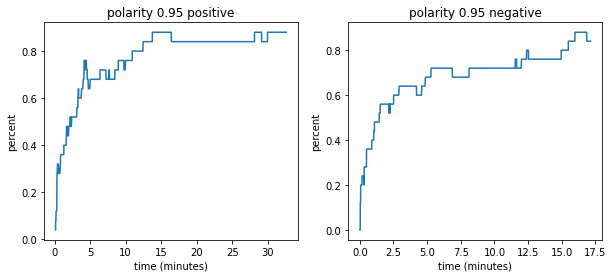

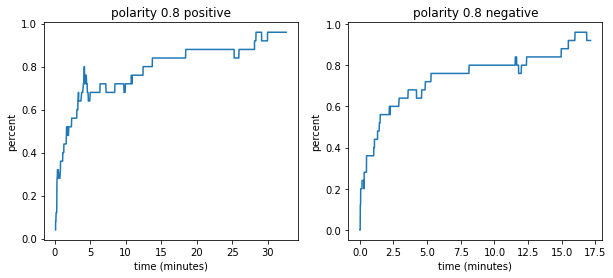

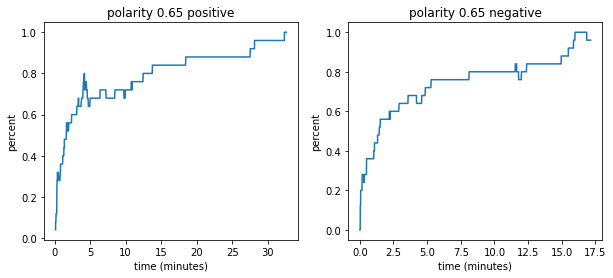

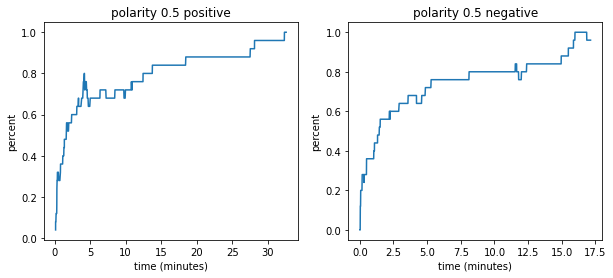

In [115]:
present_alpha_monitor()

In [102]:
def present_alpha_score_monitor():
    """
    compare best topk negative and positive anchors scores between current result and the
    default running (without optimizations) top scores
    """
    top = 25
    df = pd.read_excel(f'{folder_name}/scores.xlsx').drop(0).head(top)
    pos_lines = get_lines(f'{folder_name}/pos_monitor.csv')
    neg_lines = get_lines(f'{folder_name}/neg_monitor.csv')
    time_lines = [float(line[0]) for line in get_lines(f'{folder_name}/time_monitor.csv')]
    
    pos_lines, neg_lines, pos_time, neg_time = arrange_predictions(pos_lines, neg_lines, time_lines, "predictions.pickle")

    alphas = [0.95, 0.8, 0.65, 0.5]
    results = dict.fromkeys(alphas, {'pos': [], 'neg': []})
    
    for i, alpha in enumerate(alphas): 
        top_pos = set(df[f'{alpha}-positive'].to_list())
        top_neg = set(df[f'{alpha}-negative'].to_list())
        
        pos_scores, neg_scores, max_pos, max_neg = get_scores_dict(top, "scores.xlsx", alpha)
        
        results[alpha]['pos'] = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
        results[alpha]['neg'] = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines]
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].plot(pos_time , results[alpha]['pos'], label = 'positive')
        axs[1].plot(neg_time , results[alpha]['neg'], label = 'negative')
        axs[0].set_title(f'{sorting} {alpha} positive')
        axs[1].set_title(f'{sorting} {alpha} negative')
        axs[0].set_ylim([0.0, max_pos])
        axs[1].set_ylim([0.0, max_neg])

        for ax in axs.flat:
            ax.set(xlabel='time (minutes)', ylabel='sum scores')

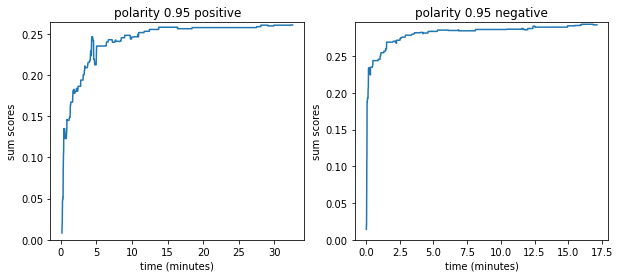

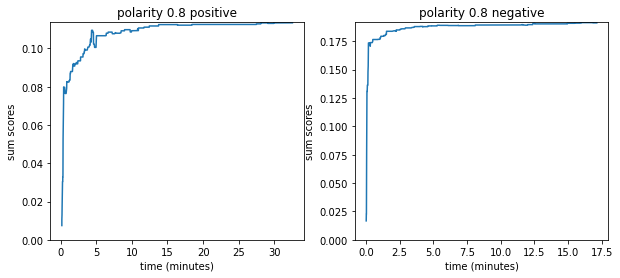

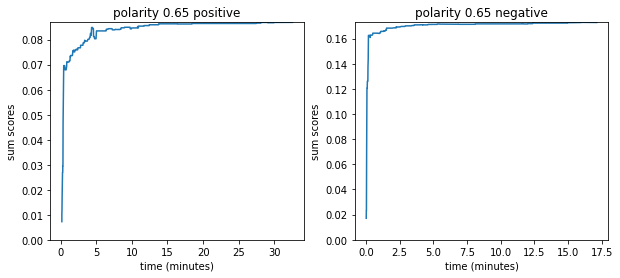

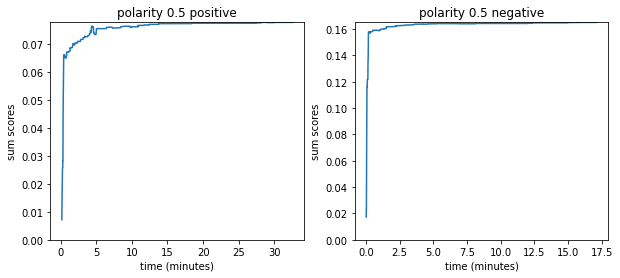

In [116]:
present_alpha_score_monitor()

In [5]:
def present_group_monitor():
    """
    compare best topk negative and positive anchors between current result and the
    final result of this optimization
    """
    top = 25
    
    pos_lines = get_lines(f'{folder_name}/pos_monitor.csv')
    neg_lines = get_lines(f'{folder_name}/neg_monitor.csv')
    time_lines = [float(line[0]) for line in get_lines(f'{folder_name}/time_monitor.csv')]

    results = dict()
    
    top_pos = set(pos_lines[-1])
    top_neg = set(neg_lines[-1])

    results['pos'] = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
    results['neg'] = [len(top_neg.intersection(set(line)))/top for line in neg_lines]

    plt.plot(time_lines, results['pos'], label = 'positive')
    plt.plot(time_lines, results['neg'], label = 'negative')
    plt.xlabel('time (minutes)')
    plt.ylabel('percent')

    plt.legend()
    plt.show()  

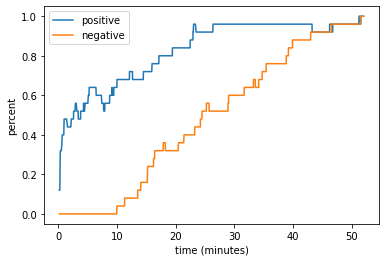

In [17]:
present_group_monitor()

In [121]:
from collections import defaultdict
    
def present_deltas_monitor(deltas):
    """ 
    compare final topk for different deltas to the default delta (0.1)
    """
    top = 25
        
    default_pos = get_lines(f'{folder_name}/{0.1}/pos_monitor.csv')
    default_neg = get_lines(f'{folder_name}/{0.1}/neg_monitor.csv')
    default_time = [float(line[0]) for line in get_lines(f'{folder_name}/{0.1}/time_monitor.csv')]
    default_pos, default_neg ,default_pos_time , default_neg_time = arrange_predictions(default_pos, default_neg, default_time)
    default_results = dict()
    
    top_pos = set(default_pos[-1])
    top_neg = set(default_neg[-1])
    
    default_results['pos'] = [len(top_pos.intersection(set(line)))/top for line in default_pos]
    default_results['neg'] = [len(top_neg.intersection(set(line)))/top for line in default_neg]
    
    results = defaultdict(dict)
    
    for delta in deltas:
        pos_lines = get_lines(f'{folder_name}/{delta}/pos_monitor.csv')
        neg_lines = get_lines(f'{folder_name}/{delta}/neg_monitor.csv')
        time_lines = [float(line[0]) for line in get_lines(f'{folder_name}/{delta}/time_monitor.csv')]
        pos_lines, neg_lines, pos_time, neg_time = arrange_predictions(pos_lines, neg_lines, time_lines)
        results['pos_time'][delta] = pos_time
        results['neg_time'][delta] = neg_time
        results['pos'][delta] = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
        results['neg'][delta] = [len(top_neg.intersection(set(line)))/top for line in neg_lines]
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 18))
    axs[0].plot(default_pos_time, default_results['pos'], label = 'default (0.1)')
    axs[0].set_title(f'{dataset_name} {sorting} positive')
    axs[1].plot(default_neg_time, default_results['neg'], label = 'default (0.1)')
    axs[1].set_title(f'{dataset_name} {sorting} negative')
    
    for delta in deltas:
        axs[0].plot(results['pos_time'][delta] , results['pos'][delta], label = str(delta))
        axs[1].plot(results['neg_time'][delta] , results['neg'][delta], label = str(delta))
        
    for ax in axs.flat:
        ax.set(xlabel='time (minutes)', ylabel='percent')
        ax.legend()

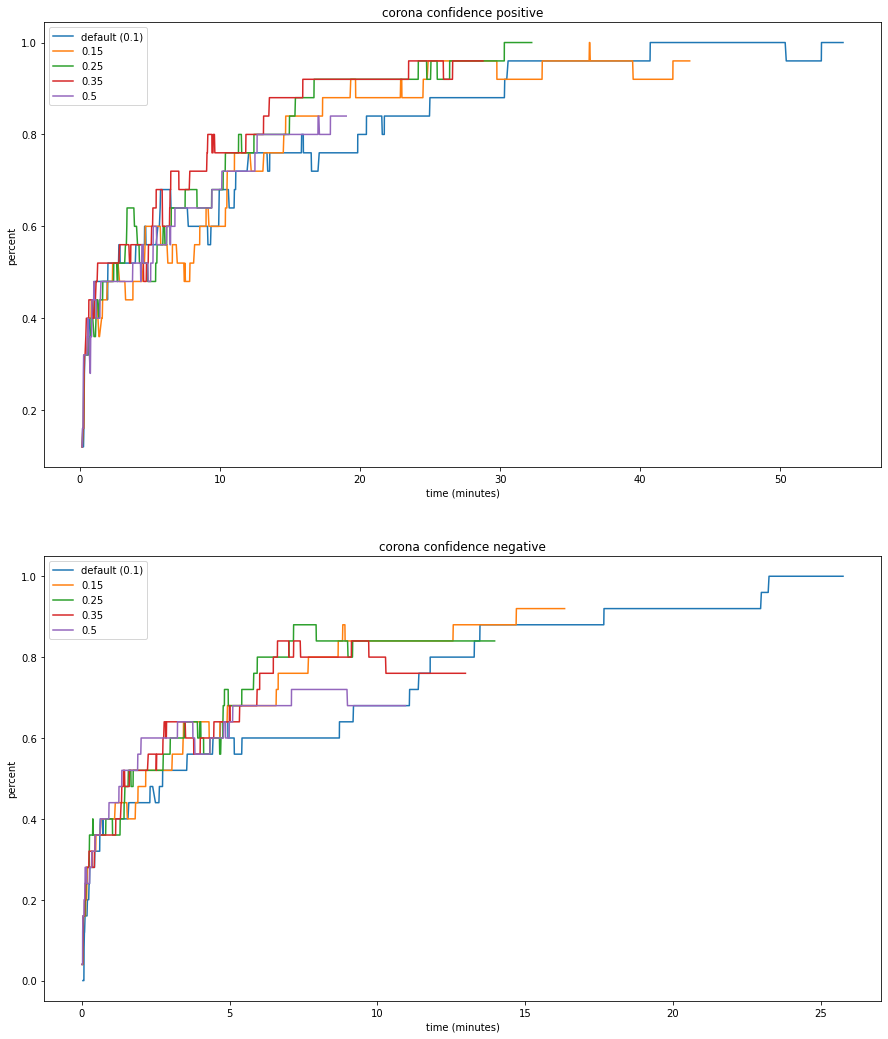

In [134]:
#deltas = [0.15, 0.20, 0.25, 0.3, 0.35, 0.5]
deltas = [0.15, 0.25, 0.35, 0.5]
present_deltas_monitor(deltas)

In [188]:
from math import sqrt
def present_deltas_score_monitor(deltas):
    """ 
    compare final topk score for different deltas to the default delta (0.1)
    """
    top = 25
    
    pos_scores, neg_scores, max_pos, max_neg = get_scores_dict()
    
    default_pos = get_lines(f'{folder_name}/{0.1}/pos_monitor.csv')
    default_neg = get_lines(f'{folder_name}/{0.1}/neg_monitor.csv')
    default_time = [float(line[0]) for line in get_lines(f'{folder_name}/{0.1}/time_monitor.csv')]
    default_pos, default_neg ,default_pos_time , default_neg_time = arrange_predictions(default_pos, default_neg, default_time)
    default_results = dict()
    
    default_results['pos'] = [sum(pos_scores.get(x, 0.0) for x in line) for line in default_pos]
    default_results['neg'] = [sum(neg_scores.get(x, 0.0) for x in line) for line in default_neg]
    
    results = defaultdict(dict)
    
    for delta in deltas:
        pos_lines = get_lines(f'{folder_name}/{delta}/pos_monitor.csv')
        neg_lines = get_lines(f'{folder_name}/{delta}/neg_monitor.csv')
        time_lines = [float(line[0]) for line in get_lines(f'{folder_name}/{delta}/time_monitor.csv')]
        pos_lines, neg_lines, pos_time, neg_time = arrange_predictions(pos_lines, neg_lines, time_lines)
        results['pos_time'][delta] = pos_time
        results['neg_time'][delta] = neg_time
        results['pos'][delta] = [sum(pos_scores.get(x, 0.0) for x in line) for line in pos_lines]
        results['neg'][delta] = [sum(neg_scores.get(x, 0.0) for x in line) for line in neg_lines]
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 18))
    axs[0].plot(default_pos_time, default_results['pos'], label = 'default (0.1)')
    axs[0].set_title(f'{dataset_name} {sorting} positive')
    axs[0].set_ylim([0.0, max_pos])
    axs[1].plot(default_neg_time, default_results['neg'], label = 'default (0.1)')
    axs[1].set_title(f'{dataset_name} {sorting} negative')
    axs[1].set_ylim([0.0, max_neg])
                  
    for delta in deltas:
        axs[0].plot(results['pos_time'][delta] , results['pos'][delta], label = str(delta))
        axs[1].plot(results['neg_time'][delta] , results['neg'][delta], label = str(delta))
           
    for ax in axs.flat:
        ax.set(xlabel='time (minutes)', ylabel='sum scores')
        ax.legend()

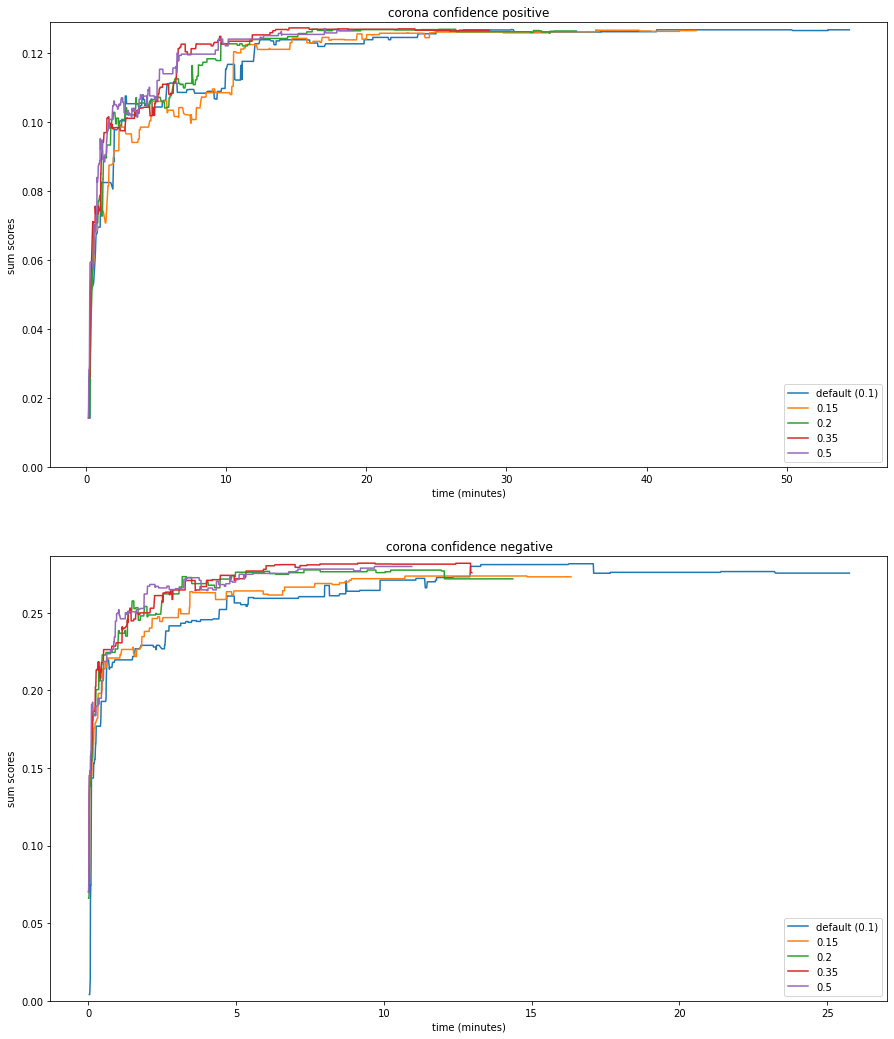

In [189]:
#deltas = [0.15, 0.20, 0.25, 0.3, 0.35, 0.5]
deltas = [0.15, 0.20, 0.35, 0.5]
present_deltas_score_monitor(deltas)

In [144]:
def compare_seeds(seeds):
    """
    compare best negative and positive scores between different seeds (all without optimizations)
    """               
    alpha = 0.95
    top = 25
    dfs = [pd.read_excel(f'results/{dataset_name}/{sorting}/seed/{seed}/scores.xlsx').drop(0) for seed in seeds]
    pos_results, neg_results = [], []
    
    for seed1, df1 in zip(seeds, dfs):
        pos_percentages, neg_percentages = [seed1], [seed1]
        
        for seed2, df2 in zip(seeds, dfs): 
            pos_percentages.append(intersect_df(df1[f'{alpha}-positive'], df2[f'{alpha}-positive'], top))
        
            neg_percentages.append(intersect_df(df1[f'{alpha}-negative'], df2[f'{alpha}-negative'], top))
            
        
        pos_results.append(pos_percentages)
        neg_results.append(neg_percentages)
    
    df_pos = pd.DataFrame(data = pos_results, columns = ['seed - positive']+seeds).set_index('seed - positive')
    df_neg = pd.DataFrame(data = neg_results, columns = ['seed - negative']+seeds).set_index('seed - negative')
    return df_pos, df_neg

In [149]:
df_pos, df_neg = compare_seeds([42, 84, 126, 168])

In [150]:
df_pos

,42,84,126,168
seed - positive,,,,
42,1.00,0.96,0.96,0.92
84,0.96,1.00,0.92,0.88
126,0.96,0.92,1.00,0.96
168,0.92,0.88,0.96,1.00


In [151]:
df_neg

,42,84,126,168
seed - negative,,,,
42,1.00,0.88,0.88,0.88
84,0.88,1.00,0.84,0.80
126,0.88,0.84,1.00,0.84
168,0.88,0.80,0.84,1.00


In [197]:
def compare_seeds_scores(seeds):
    """
    compare best negative and positive scores between different seeds (all without optimizations)
    """               
    alpha = 0.95
    top = 25
    dfs = [pd.read_excel(f'results/{dataset_name}/{sorting}/seed/{seed}/scores.xlsx').drop(0) for seed in seeds]
    pos_results, neg_results = [], []
    
    for seed1, df1 in zip(seeds, dfs):
        pos_percentages, neg_percentages = [seed1], [seed1]
        pos_scores, neg_scores, max_pos, max_neg = get_scores_dict(top, trail_path = f"seed/{seed1}/scores.xlsx")
        for seed2, df2 in zip(seeds, dfs): 
            df2_top = df2[f'{alpha}-positive'].head(top).tolist()
            df2_score = sum(pos_scores.get(x, 0.0) for x in df2_top)
            pos_percentages.append(max_pos - df2_score)
            
            df2_top = df2[f'{alpha}-negative'].head(top).tolist()
            df2_score = sum(neg_scores.get(x, 0.0) for x in df2_top)
            neg_percentages.append(max_neg - df2_score)
            
        pos_results.append(pos_percentages)
        neg_results.append(neg_percentages)
    
    df_pos = pd.DataFrame(data = pos_results, columns = ['seed - positive']+seeds).set_index('seed - positive')
    df_neg = pd.DataFrame(data = neg_results, columns = ['seed - negative']+seeds).set_index('seed - negative')
    return df_pos, df_neg

In [198]:
df_pos, df_neg = compare_seeds_scores([42, 84, 126, 168])

In [199]:
df_pos

,42,84,126,168
seed - positive,,,,
42,0.000000,0.000451,0.000406,0.001041
84,0.000121,0.000000,0.000262,0.000505
126,0.000707,0.001437,0.000000,0.001646
168,0.001281,0.001767,0.000367,0.000000


In [200]:
df_neg

,42,84,126,168
seed - negative,,,,
42,0.000000,0.002654,0.006025,0.004121
84,0.000374,0.000000,0.001371,0.001141
126,0.001412,0.004261,0.000000,0.002321
168,0.002307,0.002640,0.004016,0.000000
